**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [4]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [5]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [6]:
Gap30 = dv30M.add_formula('gap30', 'close-Delay(open, 1)',add_data=True)

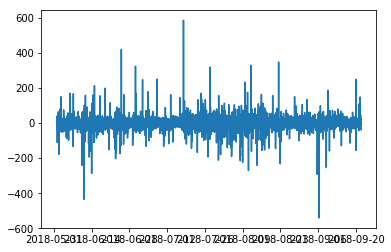

In [7]:
#30min的图
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap30', date_type='datetime')["BTCUSDT:binance"])
plt.show()

In [8]:
Gap1H = dv1H.add_formula('gap1H', 'close-Delay(open, 1)',add_data=True)

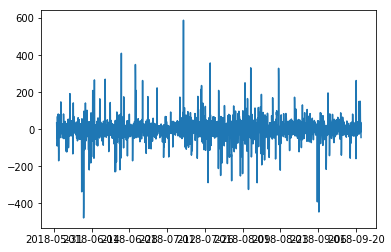

In [9]:
import matplotlib.pyplot as plt


plt.plot(dv1H.get_ts('gap1H', date_type='datetime')["BTCUSDT:binance"])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [10]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),\
                      If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [11]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()

In [12]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

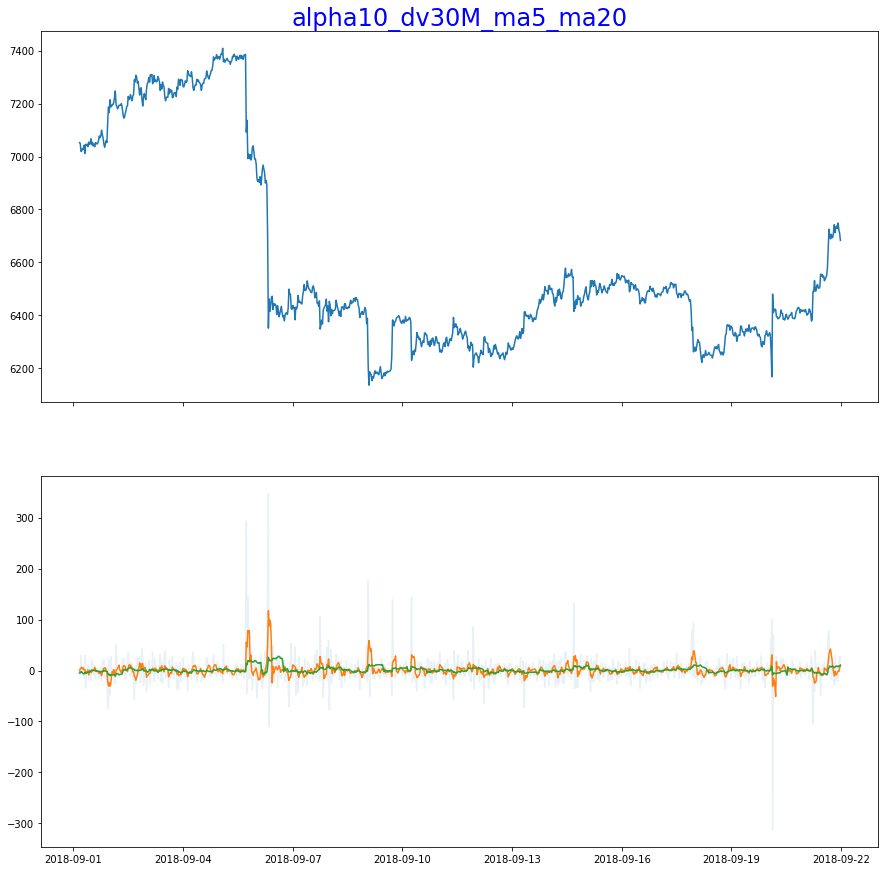

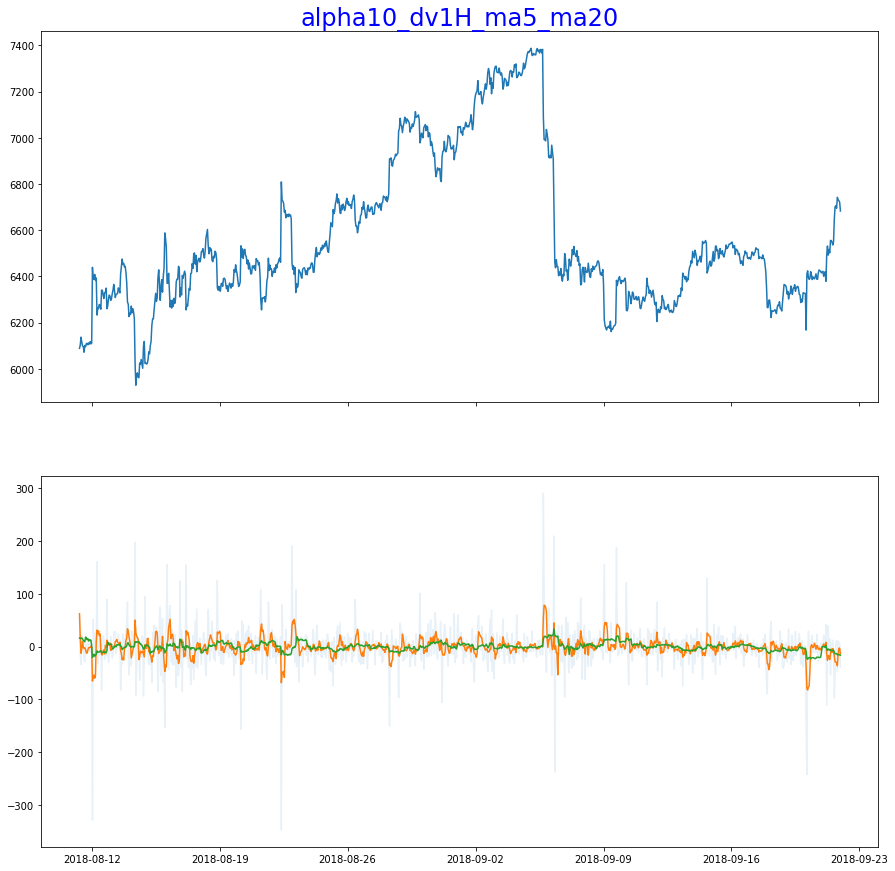

In [13]:
import pandas as pd
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',\
              ShortPeriod=5, LongPeriod=20, n=-1000)

In [14]:
long = dv1H.add_formula("longAlpha1","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha1","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

close_long = dv1H.add_formula("closeLongAlpha1","If(shortAlpha1==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha1","If(longAlpha1==2,-1,0)", add_data=True)

In [15]:
dv1H.get_ts('longAlpha1').stack()[dv1H.get_ts('longAlpha1').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [16]:
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')
tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')
def TimingSignal(td, dv, long, short,closeLong, closeShort, mhp,sl,sp):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [17]:
TimingSignal(tdAlpha1, dv1H,long='longAlpha1',short='shortAlpha1',closeLong='closeLongAlpha1',\
             closeShort='closeShortAlpha1', mhp=100, sl=0.05, sp=0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [18]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [19]:
import warnings
warnings.filterwarnings("ignore")

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

In [20]:
data1H = Time_dict.set_index('datetime')

In [21]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [22]:
import matplotlib.pyplot as plt
#import mpl_finance as mpf
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [23]:
Morning_star=dv1H.add_formula('Morning_star',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),\
                            100,0)",add_data=True)

In [24]:
MoringstarVolume=dv1H.get_ts('Morning_star', date_type='datetime')
MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [25]:
MoringstarVolumeX = MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100].index
MoringstarVolumeY = data1H.loc[MoringstarVolumeX].low-100

In [26]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

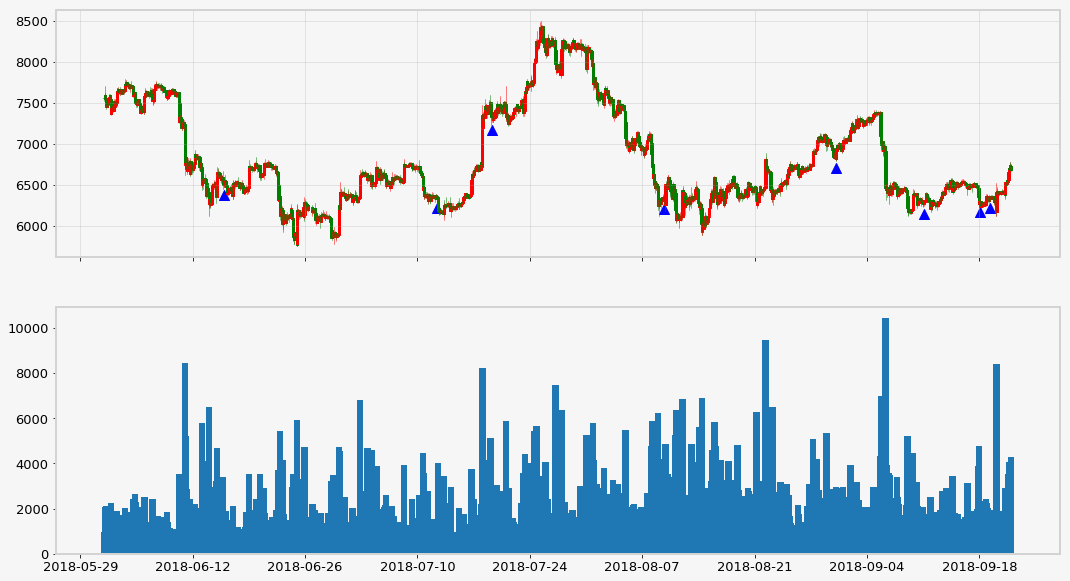

In [27]:
draw_candle(candle, MoringstarVolumeX, MoringstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [63]:
#读取数据：
#数据类型：BTCUSDT:binance
#数据周期：1小时K线图
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol':'BTCUSDT:binance','freq':"1H",
         'start_date':20180701000000}  #起始时间：2018.08.01

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.4525840282440186


In [64]:
#数据初始化
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H_new = HFDataView()
dv1H_new.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [321]:
#1.调用因子1:RSI-相对强弱指标

dv1H_new.add_formula('Ui_12',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_new.add_formula('Di_12',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_new.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui_12,Ui_12,Ui_12,Ui_12,\
                        Ui_12,12)/Ta('MA',0,Di_12,Di_12,Di_12,Di_12,Di_12,12)))",add_data=True)

dv1H_new.add_formula('Ui_6',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_new.add_formula('Di_6',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_new.add_formula('RSI_6',"100-100/(1+(Ta('MA',0,Ui_6,Ui_6,Ui_6,Ui_6,\
                    Ui_6,6)/Ta('MA',0,Di_6,Di_6,Di_6,Di_6,Di_6,6)))",add_data=True)

Field [Ui_12] is overwritten.
Field [Di_12] is overwritten.
Field [RSI_12] is overwritten.
Field [Ui_6] is overwritten.
Field [Di_6] is overwritten.
Field [RSI_6] is overwritten.


In [322]:
import matplotlib.pyplot as plt

def plot_chart1(close,alpha1,alpha2):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha1.iloc[-1000:],'g', label='RSI_12')
    ax1.plot(alpha2.iloc[-1000:],'r', label='RSI_6')
    ax1.axhline(80,alpha=0.3,)
    ax1.axhline(20,alpha=0.3,)
    plt.legend()
    plt.show()

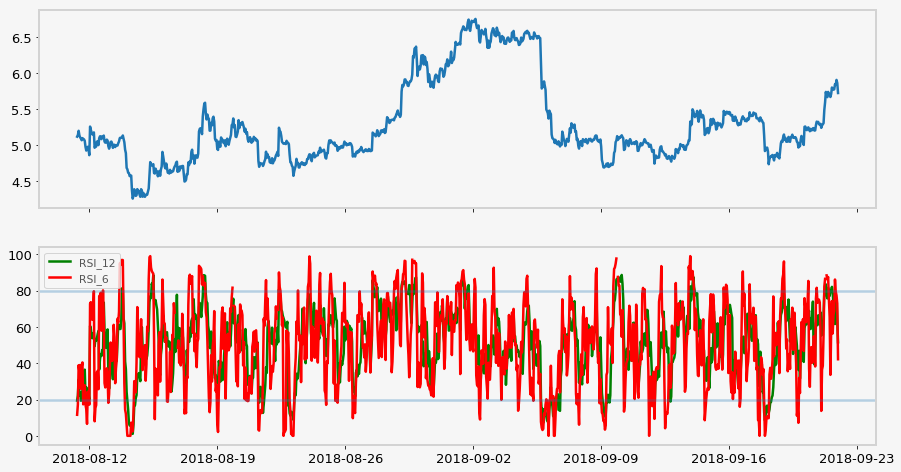

In [324]:
RSI_plot_12 = dv1H_new.get_ts('RSI_12', date_type='datetime')
RSI_plot_6 = dv1H_new.get_ts('RSI_6', date_type='datetime')
close1 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart1(close1, RSI_plot_12,RSI_plot_6)

In [ ]:
#因子1研究报告
#因子：调用技术因子RSI,分别是6日短期RSI与12日长期RSI
#现象：画图比较了股票收盘价与多空双方买卖力量相对强弱的关系。
#描述：当RSI取值为50时，股票的买入力量与卖出力量一致，股价不变，RSI取值越大，股票买入力度越大，股票价格会上涨；
     #RSI取值越小，股票卖出力度越大，股票价格会下跌。同时，短期RSI大于长期RSI为多头市场，反之为空头市场。

In [325]:
#2.调用因子2:ROC-价格变化率
ROC12=dv1H_new.add_formula('ROC12', '((close/Delay(close,12))-1)*100',add_data=True)#采用市场流行的12天价格变化率

Field [ROC12] is overwritten.


In [326]:
import matplotlib.pyplot as plt

def plot_chart2(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:],'r', label='ROC_12')
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

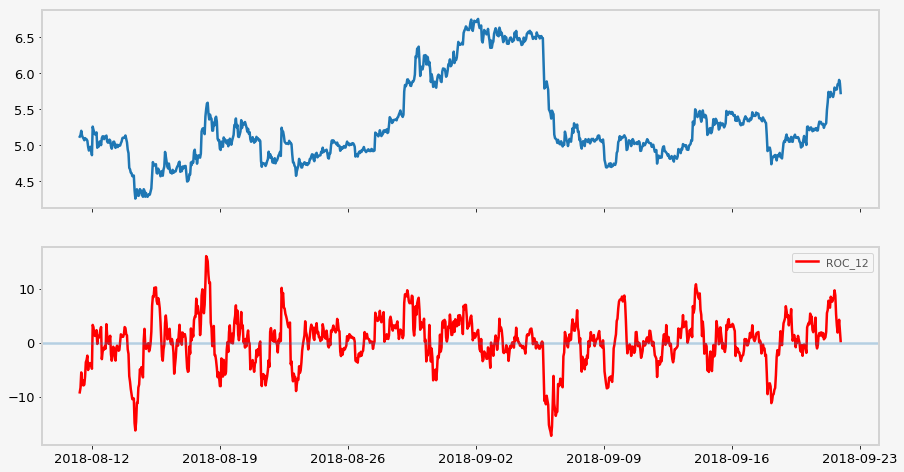

In [327]:
ROC_plot = dv1H_new.get_ts('ROC12', date_type='datetime')
close2 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart2(close2, ROC_plot)

In [347]:
#因子2研究报告
#因子：调用技术因子ROC
#现象：来反映股票市股价变动的快慢程度，显示当前股价趋势的加速和减速状态
#描述：ROC表示股价上升或下降的速率大小。
    #如果是上升趋势，并且ROC为正值,另外ROC步步上扬,则意味着上升趋势正在加速，若ROC开始走平,这就意味着,
    #股价的涨幅与数天前的股价涨幅相近,尽管还处于上升趋势,但速度已经放慢;若ROC开始回落,虽然股价还在上升,但上升的力量已经衰落;
    #若ROC开始延伸到0之下,下降趋势已开始露头,ROC进一步向下,则下降动力正在加强。
    #下降趋势类似
#适用于波段行情，实现超买超卖进出场。

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [328]:
#因子1:RSI-相对强弱指标
#联系：买方和卖方力量的消长会影响股票的价格。买方力量大，股票上涨；卖方力量大，股票下跌。RSI是衡量买卖双方力量强弱的指标。
#信号1：超买超卖现象。当RSI大于80，股票出现超买信号，股票买入力量过大，买入力量在未来可能会减小，所以股票未来价格可能会下跌。
              # 当RSI小于20时，股票出现超卖信号，股票卖出力量过大，卖出力量在未来可能会减小，所以股票未来价格可能会上涨。
#信号2：短期RSI与长期RSI交叉现象。当短期RSI大于长期RSI时，多头市场占主要优势；当短期RSI小于长期RSI时，空头市场占优势。
#信号进出场假设：
#进场信号，长期RSI在20以下超卖区内，且短期RSI大于长期RSI时，为做多讯号；或长期RSI在80以上超买区内，且短期RSI小于长期RSI时，为做空讯号
#出场信号，长期RSI>80或短期RSI小于长期RSI任一条件满足，平多单；或长期RSI<20或短期RSI大于长期RSI任一条件满足，平空单

In [345]:
#进场信号
RSIlong = dv1H_new.add_formula("RSILong","If((RSI_12<20)&&(RSI_6>RSI_12),2,0)",add_data=True)
RSIshort = dv1H_new.add_formula("RSIShort","If((RSI_12>80)&&(RSI_6<RSI_12),-2,0)",add_data=True)
#出场信号
RSIcloselong = dv1H_new.add_formula("RSIcloseLong","If(RSIShort==-2,1,0)",add_data=True)
RSIcloseshort = dv1H_new.add_formula("RSIcloseShort","If(RSILong==2,-1,0)",add_data=True)

In [346]:
dv1H_new.get_ts("RSILong").stack()[dv1H_new.get_ts("RSILong").stack()==2].head()

trade_date      symbol         
20180709130000  EOSUSDT:binance    2.0
20180710070000  EOSUSDT:binance    2.0
20180710090000  EOSUSDT:binance    2.0
20180710100000  EOSUSDT:binance    2.0
20180719130000  EOSUSDT:binance    2.0
dtype: float64

In [ ]:
#因子2:ROC-价格变化率
#联系：ROC是显示一定时间间隔的两头的股价的相对差价。ROC上升,则股价涨幅比数天前的股价有所上升。
      #ROC走平，则当前股价涨幅仅仅同数天前一样。ROC向下，则股价已经比数天前的涨幅小了。
      #ROC的变化总是领先于股价的变化，比价格提前几天上升或下降
#信号：ROC值是否穿过0基准线。ROC自上而下跌破0,是卖出信号。反之，ROC自下而上穿过0,是买进信号。
      #由于其变化具有领先性，所以当ROC变化时，价格可能还没变化；同时，ROC指标由于其特性具有十分敏感的性质，尤其在0线附近。
      #为了避免以上问题，可以适当增大阈值来提高收益率。修正后为ROC自上而下跌破-2,是卖出信号。反之，ROC自下而上穿过2,是买进信号。
#信号进出场假设：
#进场信号，如果出现12日ROC>2且前一个小时的12日ROC<2的信号时,买入,做多;如果出现12日ROC<-2且前一个小时的12日ROC>-2的信号时,卖出,做空。
#出场信号，如果出现12日ROC<2且前一个小时的12日ROC>2的信号时,平多单;如果出现12日ROC>-2且前一个小时的12日ROC<-2的信号时,平空单。

In [349]:
#进场信号
ROClong = dv1H_new.add_formula("ROCLong","If((ROC12>2) && (Delay(ROC12,1)<2),2,0)",add_data=True)
ROCshort = dv1H_new.add_formula("ROCShort","If((ROC12<-2) && (Delay(ROC12,1)>-2),-2,0)",add_data=True)
#出场信号
ROCcloselong = dv1H_new.add_formula("ROCcloseLong","If(ROCShort==-2,1,0)",add_data=True)
ROCcloseshort = dv1H_new.add_formula("ROCcloseShort","If(ROCLong==2,-1,0)",add_data=True)

In [351]:
dv1H_new.get_ts("ROCLong").stack()[dv1H_new.get_ts("ROCLong").stack()==2].head()

trade_date      symbol         
20180702100000  EOSUSDT:binance    2.0
20180702210000  EOSUSDT:binance    2.0
20180704210000  EOSUSDT:binance    2.0
20180705010000  EOSUSDT:binance    2.0
20180705180000  EOSUSDT:binance    2.0
dtype: float64

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [352]:
#因子1:RSI-相对强弱指标  假设落实

In [353]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdRSI = TimingDigger(output_folder=".", output_format='pdf',signal_name='RSI12')

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [354]:
TimingSignal(tdRSI,dv1H_new,"RSILong","RSIShort","RSIcloseLong","RSIcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [355]:
tdRSI.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.083 -19.466   1.230
p-value              0.000   0.000   0.224
mean                 0.131  -0.063   0.019
std                  0.106   0.019   0.119
info_ratio           1.242  -3.389   0.161
skewness             0.477   0.321   1.219
kurtosis            -1.345   2.339   0.252
pct5                 0.016  -0.095  -0.094
pct25                0.033  -0.074  -0.060
pct50                0.084  -0.059  -0.052
pct75                0.198  -0.053   0.074
pct95                0.298  -0.051   0.286
occurance           25.000  34.000  59.000
win_ratio              NaN     NaN   0.424
win_mean/loss_mean     NaN     NaN   2.078


In [356]:
tdRSI.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              10.366 -19.915   2.372
p-value              0.000   0.000   0.023
mean                 0.073  -0.070   0.027
std                  0.036   0.012   0.073
info_ratio           1.995  -5.749   0.375
skewness             0.826  -0.752  -0.239
kurtosis            -0.286   0.356  -1.134
pct5                 0.024  -0.088  -0.077
pct25                0.049  -0.076  -0.056
pct50                0.065  -0.073   0.051
pct75                0.088  -0.060   0.067
pct95                0.145  -0.056   0.136
occurance           28.000  13.000  41.000
win_ratio              NaN     NaN   0.683
win_mean/loss_mean     NaN     NaN   1.039


In [357]:
tdRSI.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.758 -25.401    2.187
p-value              0.000   0.000    0.031
mean                 0.100  -0.065    0.023
std                  0.083   0.017    0.103
info_ratio           1.214  -3.745    0.220
skewness             1.277   0.366    1.031
kurtosis             0.533   2.680    0.494
pct5                 0.017  -0.097   -0.084
pct25                0.044  -0.076   -0.060
pct50                0.067  -0.060    0.016
pct75                0.136  -0.055    0.068
pct95                0.289  -0.051    0.271
occurance           53.000  47.000  100.000
win_ratio              NaN     NaN    0.530
win_mean/loss_mean     NaN     NaN    1.542


In [358]:
#因子2:ROC-价格变化率   假设落实

In [359]:
tdROC = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC12')
TimingSignal(tdROC,dv1H_new,"ROCLong","ROCShort","ROCcloseLong","ROCcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%


In [360]:
tdROC.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.014 -10.834   1.633
p-value              0.000   0.000   0.106
mean                 0.050  -0.029   0.009
std                  0.048   0.019   0.053
info_ratio           1.057  -1.564   0.169
skewness             1.382  -0.825   1.248
kurtosis             1.342   0.457   1.768
pct5                 0.002  -0.057  -0.055
pct25                0.018  -0.044  -0.023
pct50                0.035  -0.023  -0.003
pct75                0.067  -0.017   0.031
pct95                0.146  -0.004   0.124
occurance           45.000  49.000  94.000
win_ratio              NaN     NaN   0.479
win_mean/loss_mean     NaN     NaN   1.739


In [361]:
tdROC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               6.918 -10.942    1.036
p-value              0.000   0.000    0.303
mean                 0.059  -0.032    0.006
std                  0.055   0.022    0.059
info_ratio           1.080  -1.437    0.104
skewness             1.344  -0.870    1.351
kurtosis             0.994   0.849    2.108
pct5                 0.006  -0.064   -0.062
pct25                0.022  -0.042   -0.035
pct50                0.042  -0.028   -0.006
pct75                0.083  -0.014    0.035
pct95                0.184  -0.003    0.123
occurance           42.000  59.000  101.000
win_ratio              NaN     NaN    0.416
win_mean/loss_mean     NaN     NaN    1.873


In [362]:
tdROC.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               9.857  -15.318    1.856
p-value              0.000    0.000    0.065
mean                 0.055   -0.030    0.008
std                  0.051    0.021    0.056
info_ratio           1.063   -1.481    0.133
skewness             1.390   -0.890    1.306
kurtosis             1.278    0.887    2.009
pct5                 0.002   -0.062   -0.057
pct25                0.019   -0.044   -0.028
pct50                0.039   -0.026   -0.005
pct75                0.073   -0.015    0.033
pct95                0.167   -0.003    0.125
occurance           87.000  108.000  195.000
win_ratio              NaN      NaN    0.446
win_mean/loss_mean     NaN      NaN    1.797


策略通用性测试：
#品种：EOSUSDT:binance
#测试周期：1小时K线图

In [363]:
#读取数据：
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props_uni = {'fields': 'open,high,low,close,volume','symbol':'EOSUSDT:binance','freq':"1H",
         'start_date':20180801000000}  #起始时间是2018.08.01

Time_dict_uni = ds.bar_reader(path,props_uni)
print(time()-start)

1.3083622455596924


In [364]:
#数据初始化
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H_uni = HFDataView()
dv1H_uni.create_init_dv(Time_dict_uni.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [258]:
#1、因子1 RSI—相对强弱指标 策略通用性测试

In [365]:
dv1H_uni.add_formula('Ui_12',"If(close>Delay(close,1),close-Delay(close,1),If(close<Delay(close,1),0,0))",add_data=True)
dv1H_uni.add_formula('Di_12',"If(close>Delay(close,1),0,If(close<Delay(close,1),Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_uni.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui_12,Ui_12,Ui_12,Ui_12,Ui_12,12)/Ta('MA',0,Di_12,Di_12,Di_12,Di_12,Di_12,12)))",add_data=True)

dv1H_uni.add_formula('Ui_6',"If(close>Delay(close,1),close-Delay(close,1),If(close<Delay(close,1),0,0))",add_data=True)
dv1H_uni.add_formula('Di_6',"If(close>Delay(close,1),0,If(close<Delay(close,1),Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_uni.add_formula('RSI_6',"100-100/(1+(Ta('MA',0,Ui_6,Ui_6,Ui_6,Ui_6,Ui_6,6)/Ta('MA',0,Di_6,Di_6,Di_6,Di_6,Di_6,6)))",add_data=True)

In [366]:
import matplotlib.pyplot as plt

def plot_chart1(close,alpha1,alpha2):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha1.iloc[-1000:],'g', label='RSI_12')
    ax1.plot(alpha2.iloc[-1000:],'r', label='RSI_6')
    ax1.axhline(80,alpha=0.3,)
    ax1.axhline(20,alpha=0.3,)
    plt.legend()
    plt.show()

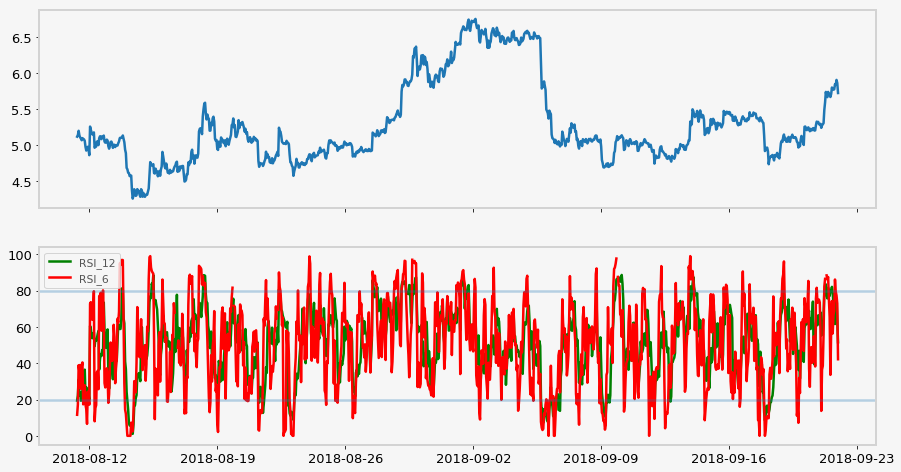

In [367]:
RSI_plot_12 = dv1H_uni.get_ts('RSI_12', date_type='datetime')
RSI_plot_6 = dv1H_uni.get_ts('RSI_6', date_type='datetime')
close1 = dv1H_uni.get_ts('close', date_type='datetime')
plot_chart1(close1, RSI_plot_12,RSI_plot_6)

In [368]:
#进场信号，如果当RSI<20,且短期RSI大于长期RSI时，买入信号，做多；
        #或者当RSI>80,且短期RSI小于长期RSI时，卖出信号，做空
RSIlong = dv1H_uni.add_formula("RSILong","If((RSI_12<20)&&(RSI_6>RSI_12),2,0)",add_data=True)
RSIshort = dv1H_uni.add_formula("RSIShort","If((RSI_12>80)&&(RSI_6<RSI_12),-2,0)",add_data=True)
#出场信号，当满足RSI>80或短期RSI小于长期RSI任一条件满足时开空单，平多仓；
         #当RSI<20或短期RSI大于长期RSI任一条件满足，平空单
RSIcloselong = dv1H_uni.add_formula("RSIcloseLong","If(RSIShort==-2,1,0)",add_data=True)
RSIcloseshort = dv1H_uni.add_formula("RSIcloseShort","If(RSILong==2,-1,0)",add_data=True)

In [369]:
dv1H_uni.get_ts("RSILong").stack()[dv8H_uni.get_ts("RSILong").stack()==2].head()

trade_date      symbol         
20180802200000  EOSUSDT:binance    2.0
20180805000000  EOSUSDT:binance    2.0
20180805030000  EOSUSDT:binance    2.0
20180805040000  EOSUSDT:binance    2.0
20180806210000  EOSUSDT:binance    2.0
dtype: float64

In [338]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdRSI = TimingDigger(output_folder=".", output_format='pdf',signal_name='RSI12')

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [370]:
TimingSignal(tdRSI,dv1H_uni,"RSILong","RSIShort","RSIcloseLong","RSIcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [371]:
tdRSI.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.876 -15.368   1.710
p-value              0.000   0.000   0.094
mean                 0.136  -0.065   0.032
std                  0.109   0.021   0.126
info_ratio           1.253  -3.137   0.249
skewness             0.350   0.564   1.000
kurtosis            -1.480   1.899  -0.338
pct5                 0.016  -0.097  -0.094
pct25                0.033  -0.082  -0.060
pct50                0.086  -0.060  -0.026
pct75                0.235  -0.054   0.085
pct95                0.298  -0.051   0.293
occurance           23.000  25.000  48.000
win_ratio              NaN     NaN   0.479
win_mean/loss_mean     NaN     NaN   2.102


In [372]:
tdRSI.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              10.765 -19.700   3.091
p-value              0.000   0.000   0.006
mean                 0.099  -0.063   0.056
std                  0.033   0.006   0.077
info_ratio           2.986  -9.850   0.729
skewness             0.355  -0.260  -0.622
kurtosis            -1.478  -1.462  -1.034
pct5                 0.064  -0.072  -0.069
pct25                0.066  -0.069   0.004
pct50                0.090  -0.060   0.067
pct75                0.128  -0.060   0.119
pct95                0.151  -0.056   0.151
occurance           14.000   5.000  19.000
win_ratio              NaN     NaN   0.737
win_mean/loss_mean     NaN     NaN   1.556


In [373]:
tdRSI.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               8.137 -18.258   2.716
p-value              0.000   0.000   0.008
mean                 0.122  -0.065   0.038
std                  0.090   0.019   0.115
info_ratio           1.356  -3.390   0.334
skewness             0.777   0.567   0.798
kurtosis            -0.580   2.624  -0.339
pct5                 0.016  -0.096  -0.090
pct25                0.063  -0.076  -0.059
pct50                0.087  -0.060   0.017
pct75                0.179  -0.055   0.102
pct95                0.297  -0.051   0.282
occurance           37.000  30.000  67.000
win_ratio              NaN     NaN   0.552
win_mean/loss_mean     NaN     NaN   1.890


In [ ]:
#2、因子2 ROC-价格变化率 策略通用性测试

In [374]:
ROC12=dv1H_uni.add_formula('ROC12', '((close/Delay(close,12))-1)*100',add_data=True)#采用市场流行的12天价格变化率

In [375]:
import matplotlib.pyplot as plt

def plot_chart2(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close)
    ax1.plot(alpha,'r', label='ROC_12')
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

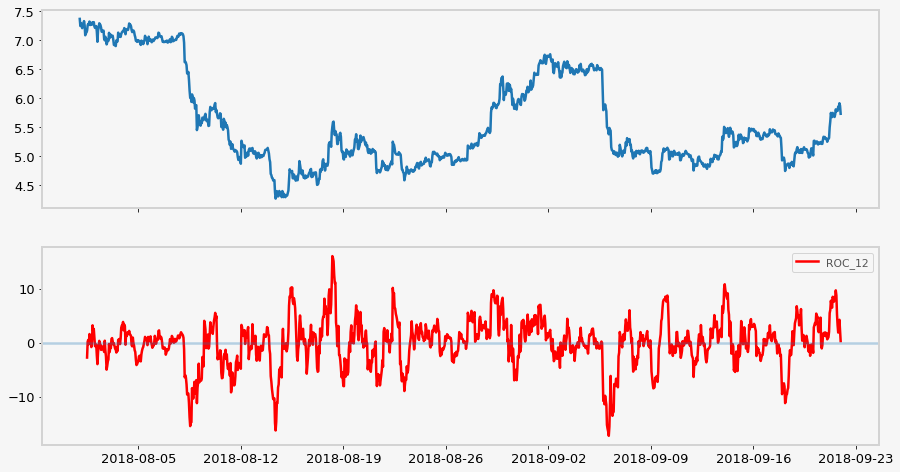

In [376]:
ROC_plot = dv1H_uni.get_ts('ROC12', date_type='datetime')
close2 = dv1H_uni.get_ts('close', date_type='datetime')
plot_chart2(close2, ROC_plot)

In [377]:
#进场信号,如果出现12日ROC>2且前一个小时的12日ROC<2的信号时,买入,做多;如果出现12日ROC<-2且前一个小时的12日ROC>-2的信号时,卖出,做空。
ROClong = dv1H_uni.add_formula("ROCLong","If((ROC12>2) && (Delay(ROC12,1)<2),2,0)",add_data=True)
ROCshort = dv1H_uni.add_formula("ROCShort","If((ROC12<-2) && (Delay(ROC12,1)>-2),-2,0)",add_data=True)
#出场信号,如果出现12日ROC<2且前一个小时的12日ROC>2的信号时,平多单;如果出现12日ROC>-2且前一个小时的12日ROC<-2的信号时,平空单。
ROCcloselong = dv1H_uni.add_formula("ROCcloseLong","If(ROCShort==-2,1,0)",add_data=True)
ROCcloseshort = dv1H_uni.add_formula("ROCcloseShort","If(ROCLong==2,-1,0)",add_data=True)

In [378]:
dv1H_uni.get_ts("ROCLong").stack()[dv8H_uni.get_ts("ROCLong").stack()==2].head()

trade_date      symbol         
20180801210000  EOSUSDT:binance    2.0
20180803200000  EOSUSDT:binance    2.0
20180804090000  EOSUSDT:binance    2.0
20180806090000  EOSUSDT:binance    2.0
20180809120000  EOSUSDT:binance    2.0
dtype: float64

In [379]:
tdROC = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC12')
TimingSignal(tdROC,dv1H_uni,"ROCLong","ROCShort","ROCcloseLong","ROCcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%


In [380]:
tdROC.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.832  -8.648   2.066
p-value              0.000   0.000   0.043
mean                 0.058  -0.029   0.014
std                  0.049   0.019   0.057
info_ratio           1.189  -1.505   0.252
skewness             1.252  -0.939   1.069
kurtosis             0.937   0.657   1.096
pct5                 0.009  -0.059  -0.055
pct25                0.021  -0.043  -0.022
pct50                0.043  -0.022  -0.000
pct75                0.077  -0.016   0.041
pct95                0.152  -0.004   0.134
occurance           34.000  34.000  68.000
win_ratio              NaN     NaN   0.500
win_mean/loss_mean     NaN     NaN   1.992


In [381]:
tdROC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.405  -9.275   0.772
p-value              0.000   0.000   0.444
mean                 0.053  -0.030   0.006
std                  0.046   0.017   0.052
info_ratio           1.152  -1.693   0.106
skewness             1.096  -0.511   1.208
kurtosis             1.012  -0.153   1.393
pct5                 0.003  -0.061  -0.055
pct25                0.011  -0.039  -0.029
pct50                0.051  -0.028  -0.007
pct75                0.080  -0.017   0.039
pct95                0.136  -0.005   0.093
occurance           23.000  31.000  54.000
win_ratio              NaN     NaN   0.426
win_mean/loss_mean     NaN     NaN   1.788


In [382]:
tdROC.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.775 -12.703    2.092
p-value              0.000   0.000    0.039
mean                 0.056  -0.029    0.011
std                  0.048   0.018    0.055
info_ratio           1.173  -1.588    0.190
skewness             1.203  -0.769    1.136
kurtosis             1.013   0.380    1.248
pct5                 0.002  -0.062   -0.056
pct25                0.019  -0.039   -0.027
pct50                0.048  -0.026   -0.005
pct75                0.079  -0.015    0.042
pct95                0.150  -0.004    0.128
occurance           57.000  65.000  122.000
win_ratio              NaN     NaN    0.467
win_mean/loss_mean     NaN     NaN    1.907
